In [13]:
# Import required libraries
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Embedding, GlobalAveragePooling1D, Bidirectional, LSTM, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop, Adamax, SGD, Nadam
from keras.regularizers import L1, L2, L1L2
from datetime import datetime
import pytz
import gc
import shutil
import pickle


In [2]:
print('TensorFlow version:', tf.__version__)
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.12.0
Num GPUs Available:  0


In [3]:
# Define list of dataset
dir = '../dataset/'
datasets = [file for file in Path(dir).glob('*.csv') if not file.name == 'best_dataset.csv']

datasets


[PosixPath('../dataset/set_01_02_03_04_1_1_0_new.csv'),
 PosixPath('../dataset/set_01_02_03_04_1_1_1_new.csv'),
 PosixPath('../dataset/set_01_1_1_0_new.csv'),
 PosixPath('../dataset/set_01_02_03_04_1_0_0_new.csv'),
 PosixPath('../dataset/set_01_02_03_04_1_0_1_new.csv'),
 PosixPath('../dataset/set_01_02_03_04_0_1_1_new.csv'),
 PosixPath('../dataset/set_04_1_1_0_new.csv'),
 PosixPath('../dataset/set_01_02_03_04_0_1_0_new.csv'),
 PosixPath('../dataset/set_01_02_03_04_0_0_1_new.csv'),
 PosixPath('../dataset/set_01_02_03_04_0_0_0_new.csv')]

In [21]:
# Helper function to load data
def load_data(filename):
    print(filename)

    df = pd.read_csv(filename, header=None, encoding='utf-8').dropna()
    df.columns = ['label', 'data']

    global X, y

    X = df['data']
    y = df['label']


In [5]:
# Helper function to create train val test split
def split_dataset(X, y):
    global X_train, y_train, X_val, y_val, X_test, y_test

    # train 7 : val 2 : test 1
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=7)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.33, random_state=7)


In [6]:
# Helper function to extract feature
def extract_feature(vectorizer, X):
    vectorizer.fit(X)

    print(len(vectorizer.vocabulary_))

    global X_train, X_val, X_test

    X_train = vectorizer.transform(X_train).toarray()
    X_val = vectorizer.transform(X_val).toarray()
    X_test = vectorizer.transform(X_test).toarray()

    print(X_train.shape)
    print(X_val.shape)
    print(X_test.shape)

    return vectorizer


In [7]:
# Helper function to compile and train the model with given param
def train_model(blueprint):
    global best_val_accuracy, best_model, X_train, y_train, X_val, y_val

    keras.backend.clear_session()

    model = Sequential()
    model.add(Dense(units=blueprint.hidden_layer_size_1, activation=blueprint.activation_func, input_dim=X_train.shape[1]))

    if blueprint.dropout > 0:
        model.add(Dropout(blueprint.dropout))

    model.add(Dense(units=blueprint.hidden_layer_size_2, activation=blueprint.activation_func))

    if blueprint.dropout > 0:
        model.add(Dropout(blueprint.dropout))

    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=blueprint.optimizer(learning_rate=blueprint.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # model.summary()

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_LR_on_plateau = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5)
    history = model.fit(x=X_train, y=y_train, batch_size=blueprint.batch_size, epochs=50, verbose=2,
                        callbacks=[early_stop, reduce_LR_on_plateau], validation_data=(X_val, y_val))

    print(f'Epochs = {len(history.history["accuracy"])}')

    val_accuracy = max(history.history['val_accuracy'])

    is_best_model = False

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model

        is_best_model = True

        model.save('./best_model.h5')

        print(f'##### Best model saved with validation accuracy: {best_val_accuracy}')

    del model

    gc.collect()

    return is_best_model


In [8]:
class ModelBlueprint:
    def __init__(self, hidden_layer_size_1, hidden_layer_size_2, activation_func, dropout, optimizer, learning_rate, batch_size):
        self.hidden_layer_size_1 = hidden_layer_size_1
        self.hidden_layer_size_2 = hidden_layer_size_2
        self.activation_func = activation_func
        self.dropout = dropout
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.batch_size = batch_size

    def __str__(self):
        str = f'hidden_layer_size_1: {self.hidden_layer_size_1}, hidden_layer_size_2: {self.hidden_layer_size_2}, activation_func: {self.activation_func}, '
        str += f'dropout: {self.dropout}, optimizer: {self.optimizer}, learning_rate: {self.learning_rate}, batch_size: {self.batch_size}'

        return str


In [9]:
# Helper function for plot graph
def plot_graphs(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['train accuracy', 'val accuracy'])
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['train loss', 'val loss'])
    plt.show()


In [10]:
best_val_accuracy = 0
best_model = None
best_dataset = dir + 'best_dataset.csv'

X = None
y = None
X_train = None
y_train = None
X_val = None
y_val = None
X_test = None
y_test = None

normal_blueprint = ModelBlueprint(128, 32, 'relu', 0.2, Adam, 0.0001, 36)

# select best dataset first
for i, dataset in enumerate(datasets):
    print(i)
    print(datetime.now(pytz.timezone('Asia/Hong_Kong')).strftime('%Y-%m-%d %H:%M:%S'))

    load_data(dataset)
    split_dataset(X, y)
    vectorizer = extract_feature(CountVectorizer(), X)

    if train_model(normal_blueprint):
        shutil.copy2(dataset, best_dataset)
        pickle.dump(vectorizer.vocabulary_, open('./best_vocabulary.pkl', 'wb'))

    print()

best_model.summary()

plot_graphs(best_model.history)


0
2023-07-15 14:22:38
../dataset/set_01_02_03_04_1_1_0_new.csv
42852
(23082, 42852)
(6628, 42852)
(3265, 42852)
Epoch 1/50
642/642 - 39s - loss: 0.3059 - accuracy: 0.9228 - val_loss: 0.0976 - val_accuracy: 0.9816 - lr: 1.0000e-04 - 39s/epoch - 60ms/step
Epoch 2/50
642/642 - 40s - loss: 0.0726 - accuracy: 0.9828 - val_loss: 0.0601 - val_accuracy: 0.9843 - lr: 1.0000e-04 - 40s/epoch - 62ms/step
Epoch 3/50
642/642 - 34s - loss: 0.0427 - accuracy: 0.9892 - val_loss: 0.0551 - val_accuracy: 0.9855 - lr: 1.0000e-04 - 34s/epoch - 53ms/step
Epoch 4/50
642/642 - 37s - loss: 0.0287 - accuracy: 0.9922 - val_loss: 0.0544 - val_accuracy: 0.9848 - lr: 1.0000e-04 - 37s/epoch - 57ms/step
Epoch 5/50
642/642 - 36s - loss: 0.0205 - accuracy: 0.9946 - val_loss: 0.0577 - val_accuracy: 0.9837 - lr: 1.0000e-04 - 36s/epoch - 56ms/step
Epoch 6/50
642/642 - 30s - loss: 0.0159 - accuracy: 0.9958 - val_loss: 0.0601 - val_accuracy: 0.9840 - lr: 1.0000e-04 - 30s/epoch - 47ms/step
Epoch 7/50
642/642 - 44s - loss: 0.0

KeyboardInterrupt: 

In [ ]:
# Define a list of models
hidden_layer_size_sample = [32, 64, 128]
activation_func_sample = ['relu', 'softplus', 'softsign', 'selu', 'elu']
optimizer_sample = [Adam, RMSprop]
learning_rate_sample = [0.0001]
batch_size_sample = [12, 36, 60]
dropout_sample = [0.1, 0.2, 0.3, 0.4]

hyper_params = list(itertools.product(hidden_layer_size_sample, [32], activation_func_sample, dropout_sample,
                                      optimizer_sample, learning_rate_sample, batch_size_sample))
model_blueprints = [ModelBlueprint(hidden_layer_size_1, hidden_layer_size_2, activation_func, dropout, optimizer, learning_rate, batch_size)
                    for hidden_layer_size_1, hidden_layer_size_2, activation_func, dropout, optimizer, learning_rate, batch_size in hyper_params]

# Look at all combination of hyper_params we have
print(len(model_blueprints))

for m in model_blueprints:
    print(m)


In [ ]:
# Helper function loop all hypermeter and return the best
def train_with_all_blueprints(X_train, y_train, X_val, y_val, model_blueprints):
    models = []
    histories = []

    for i, blueprint in enumerate(model_blueprints):
        print(f'{i}: {blueprint}')

        model, history = train_model(X_train, y_train, X_val, y_val,
                                     blueprint.hidden_layer_size, blueprint.activation_func, blueprint.optimizer, blueprint.learning_rate,
                                     blueprint.epochs, blueprint.batch_size, blueprint.dropout)

        models.append(model)
        histories.append(history)

    return models, histories


def get_best_model(models, histories, model_blueprints):
    best_val_acc_overall = 0
    best_model_index = 0

    for i, model in enumerate(models):
        best_val_acc = max(model.history.history['val_accuracy'])

        if (best_val_acc > best_val_acc_overall):
            best_val_acc_overall = best_val_acc
            best_model_index = i

    return best_val_acc_overall, models[best_model_index], histories[best_model_index], model_blueprints[best_model_index]


In [ ]:
# Test each dataset with each combination of hyperparameter
best_models = []

for dataset in datasets:
    X, y = load_data(dataset)
    X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(X, y)
    X_train, X_val, X_test = extract_feature(CountVectorizer(), X, X_train, X_val, X_test)
    models, histories = train_with_all_blueprints(X_train, y_train, X_val, y_val, model_blueprints)
    val_accuracy, model, history, blueprint = get_best_model(models, histories, model_blueprints)
    loss, test_accuracy = model.evaluate(X_test, y_test)

    print(dataset)
    print(blueprint)
    print(f'Val accuracy: {val_accuracy}: Test accuracy: {test_accuracy}')

    plot_graphs(history, dataset)

    best_models.append(model)


In [14]:
# Plot confusion matrix and graph
def plot_confusion_matrix(y, y_pred, type, target_names = ['Ham', 'Spam']):
    print('Confusion matrix - ' + type)
    print(classification_report(y, y_pred, target_names=target_names))

    # Plot the confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Simple NN Confusion Matrix - ' + type)
    plt.show()

In [30]:
def resetGlobalVar():
    X = None
    y = None
    X_train = None
    y_train = None
    X_val = None
    y_val = None
    X_test = None
    y_test = None

In [49]:
# Check confusion matrix given dataset and model
def evaluateDatasetConfusionMatrix(dataset, model):
    resetGlobalVar()
    load_data(dataset)
    split_dataset(X, y)
    vectorizer = extract_feature(CountVectorizer(), X)
    y_val_pred = (model.predict(X_val) > 0.5).astype("int32")
    y_test_pred = (model.predict(X_test) > 0.5).astype("int32")
    plot_confusion_matrix(y_val, y_val_pred, 'Validation')
    plot_confusion_matrix(y_test, y_test_pred, 'Testing')

../dataset/best_dataset.csv
42852
(23082, 42852)
(6628, 42852)
(3265, 42852)
103/103 [==============================] - 2s 18ms/step
Confusion matrix - Validation
              precision    recall  f1-score   support

         Ham       0.98      0.99      0.98      3093
        Spam       0.99      0.98      0.99      3535

    accuracy                           0.98      6628
   macro avg       0.98      0.98      0.98      6628
weighted avg       0.98      0.98      0.98      6628



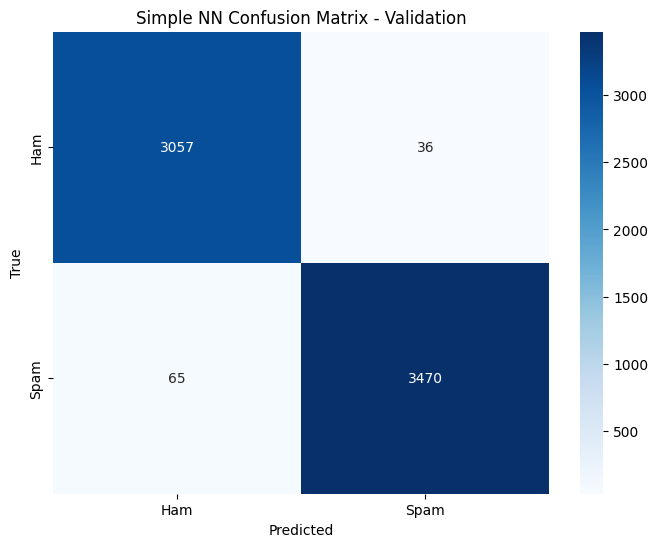

Confusion matrix - Testing
              precision    recall  f1-score   support

         Ham       0.98      0.99      0.99      1490
        Spam       0.99      0.98      0.99      1775

    accuracy                           0.99      3265
   macro avg       0.99      0.99      0.99      3265
weighted avg       0.99      0.99      0.99      3265



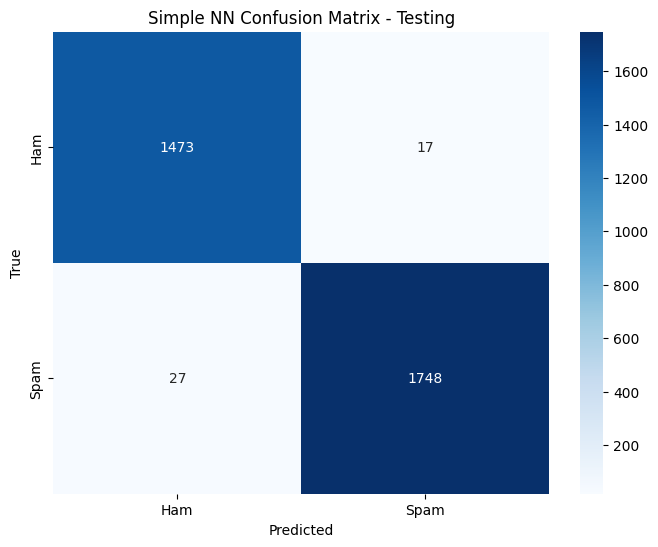

In [50]:
# Evaluate the best dataset using the best model
evaluateDatasetConfusionMatrix('../dataset/best_dataset.csv', best_model)

In [ ]:
# Test the performance of the model
def spamDetection(message):
    vectorizer = HashingVectorizer(stop_words='english', n_features=5000)
    inputMsg = vectorizer.fit_transform([message]).toarray()
    return best_model.predict(inputMsg)


# print(spamDetection('hey let grab lunch tgt next week shall we'))
# print(spamDetection('important email account has been hacked attention require click link to reset password'))
